In [2]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


#*******************************************************
# FUNCTIONS

# function to output results report
def print_results(grid, X_train, X_test, y_train, y_test):   
    # ***** Display Results *****  
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(classification_report(y_test, grid.predict(X_test)))
    print('\n')
    print(f'Best Params : {grid.best_params_}')
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(grid.best_estimator_, X_test, y_test, display_labels=['Thetruthishere', 'Supernatural'], normalize='true', ax=ax);

    
# functions to output top predictive words for each subreddit category
def top_words(X, vect):
    coefs = grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]].coef_
    coef_df = pd.DataFrame({'coefs':coefs[0]}, index = grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[0]].get_feature_names())
    most_important_25 = coef_df.nlargest(25, 'coefs')
    least_important_25 = coef_df.nsmallest(25, 'coefs')
    
    print(most_important_25)
    print(least_important_25)

<br><br>

In [14]:
stopwords = nltk.corpus.stopwords.words('english') + list(['supernatural', 'dean', 'sam', 'wa', 'episode', 'season', 'finale', 'series', 'scene', 'show', 'spoiler', 'winchester', 'character', 'chuck'])

def preprocess(text):
    no_punc = [words for words in text if words not in string.punctuation]     # strip puncutation
    text = ''.join(no_punc)
    tokens = word_tokenize(text)
    tokens = [re.sub('\d', '', words) for words in tokens]                     # strip digits
    tokens = [words for words in tokens if len(words) > 2]                     # strip words less than 3 characters long
    tokens = [WordNetLemmatizer().lemmatize(words) for words in tokens]        # apply lemmatizer
    #print(tokens)
    text = [words for words in tokens if words not in stopwords]               # strip stop words
    #print(text)
    return ' '.join(text)

In [15]:
data = pd.read_csv('../../data/cleaned_data/clean_data.csv')

X = data['selftext']
X = X.apply(lambda x : preprocess(x.lower()))
temp = data.drop(columns = ['selftext'])
temp['selftext'] = X
temp['selftext'].replace('', np.nan, inplace=True)
temp.dropna(subset=['selftext'], inplace=True)
X = temp['selftext']
y = temp['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify = y)

<br><br>

---

# Section 1

### Custom-preprocessed data with more restrictive stopwords eliminated:

### MODEL: CountVectorizer / Logistic Regression

*** TEST set ***
Score : 0.9048638727439584
                precision    recall  f1-score   support

  Supernatural       0.83      0.91      0.87      1117
Thetruthishere       0.95      0.90      0.93      2152

      accuracy                           0.90      3269
     macro avg       0.89      0.91      0.90      3269
  weighted avg       0.91      0.90      0.91      3269



Best Params : {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 0.1}
                coefs
experience   1.211872
paranormal   0.985137
video        0.818047
ufo          0.756790
strange      0.737213
alien        0.720195
light        0.682870
spiritual    0.656697
story        0.642799
experienced  0.596054
moving       0.589708
spirit       0.582326
believe      0.579781
scary        0.550917
house        0.544782
area         0.538793
information  0.531277
dream        0.518195
link         0.514244
type         0.511068
animal       0.505339
bed    

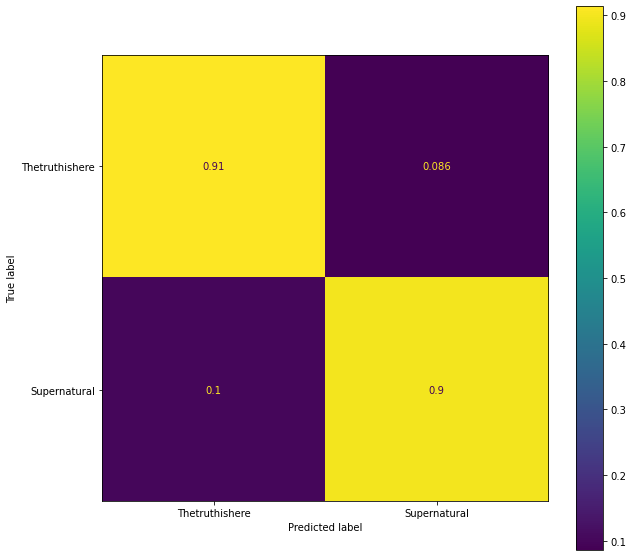

In [35]:
pipe = Pipeline([('countvectorizer', CountVectorizer()), ('logisticregression', LogisticRegression(max_iter=10_000))])
param = [
    {
        'logisticregression__C': [.1, 1, 10],
        'countvectorizer__max_features': [100, 500, 1000],
        'countvectorizer__ngram_range': [(1, 2)]
    }
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)
top_words(X_test, grid.best_estimator_.named_steps[list(grid.best_estimator_.named_steps.keys())[-1]])

<br><br>